# Segmentation 

This notebook shows how to use Cellpose (generalist algorithm for cellular segmentation) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Segment an initial image to test Cellpose parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [46]:
from octopuslite import DaskOctopusLiteLoader
from cellpose import models, io, plot
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

## 1. Load images

In [47]:
# define experiment ID and select a position
expt = 'ND0011'
pos = 'Pos6'
# point to where the data is
root_dir = '/home/nathan/data'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
# lazily load images
images = DaskOctopusLiteLoader(image_path, 
                               remove_background = False)
images.channels

Using cropping: (1200, 1600)


[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK: 99>]

Set segmentation channel and load test image 

In [27]:
# segmentation channel
segmentation_channel = images.channels[3]
# set test image index
frame = 1000
# load test image 
irfp = images[segmentation_channel.name][frame].compute()
img.shape

(1352, 1688)

## 2. Load model and test segment single image

In [31]:
# define channels for cellpose, grayscale=0, R=1, G=2, B=3, channels = [cytoplasm, nucleus]
channels = [0,0]
# set diameter of segments for cellpose, if set to None then size of cells estimated per image
diameter = None 
# Define cellpose model_type='cyto' or model_type='nuclei'
model_type='cyto'
## define model type
model = models.Cellpose(gpu=False, model_type = model_type)

2022-01-25 12:19:53,233 [INFO] >>>> using CPU


### 2.1 Test run and display initial results

2022-01-25 12:19:56,156 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2022-01-25 12:20:20,729 [INFO] estimated cell diameter(s) in 24.57 sec
2022-01-25 12:20:20,730 [INFO] >>> diameter(s) = 
2022-01-25 12:20:20,731 [INFO] [ 36.42 ]
2022-01-25 12:20:20,732 [INFO] ~~~ FINDING MASKS ~~~
2022-01-25 12:20:46,794 [INFO] >>>> TOTAL TIME 50.64 sec


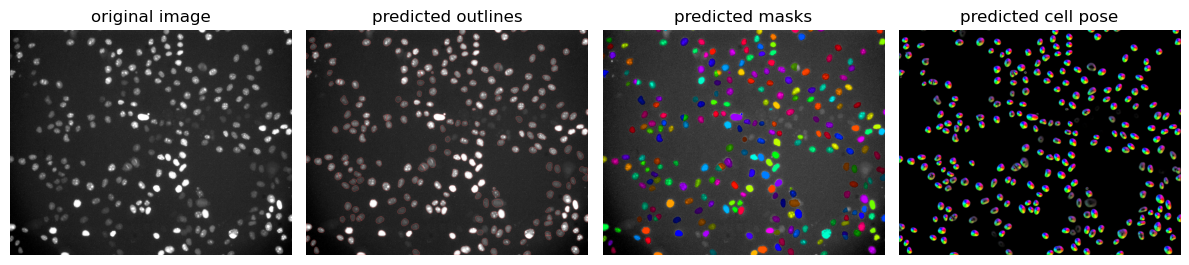

In [32]:
## run cellpose on test image
img = io.imread(images.files(segmentation_channel.name)[frame])
masks, flows, styles, diams = model.eval(img, diameter = diameter, channels = channels)
## display results
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0,0])
plt.tight_layout()
plt.show()

## 3. Batch segment a whole stack of images

When you segment a whole data set you do not want to apply any image transformation. This is so that when you load images and masks later on you can apply the same transformation. You can apply a crop but note that you need to be consistent with your use of the crop from this point on, otherwise you'll get a shift. 

In [ ]:
%%time
for expt in tqdm(['ND0009', 'ND0010', 'ND0011'], position = 0, leave = True):
    for pos in tqdm(['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4'],  position = 0, leave = True):
        print('Starting experiment position:', expt, pos)
        # load images
        image_path = os.path.join(root_dir, f'{expt}/{pos}/{pos}_images')
        images = DaskOctopusLiteLoader(image_path, 
                                      remove_background = False)
        # iterate over images filenames 
        for fn in tqdm(images.files(segmentation_channel.name), position = 0, leave = True):
            # load image
            img = io.imread(fn)
            # predict labels
            masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels)
            # set filename as mask format (channel099)
            fn = fn.replace(f'channel00{segmentation_channel.value}', 'channel099')
            # save results as png in cellpose directory
            io.save_to_png(img, masks, flows, fn)